In [ ]:
import platform
print("CPU architecture:", platform.processor())
!cat /proc/cpuinfo | grep "model name" | uniq

CPU architecture: x86_64
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from PIL import Image

Load the data

In [ ]:
def resize_and_crop_image(img, target_size):
    height, width = img.shape[:2]
    aspect_ratio = width / height

    target_aspect = target_size[0] / target_size[1]

    if aspect_ratio > target_aspect:
        intermediate_size = (int(target_size[0] * height / target_size[1]), height)
    else:
        intermediate_size = (width, int(target_size[1] * width / target_size[0]))

    img_resized = cv2.resize(img, intermediate_size, interpolation=cv2.INTER_AREA)

    crop_x = (img_resized.shape[1] - target_size[0]) // 2
    crop_y = (img_resized.shape[0] - target_size[1]) // 2

    img_cropped = img_resized[crop_y:crop_y+target_size[1], crop_x:crop_x+target_size[0]]

    return img_cropped

def preprocess_images_and_save(classes, train_path, test_path, dest_folder, val_size=0.2):
    img_size = (256, 256)
    datasets = {'train': {'data': [], 'labels': []}, 'test': {'data': [], 'labels': []}}

    for dataset_type, path in zip(['train', 'test'], [train_path, test_path]):
        for class_index, class_name in enumerate(classes):
            class_path = os.path.join(path, class_name)
            for img_name in os.listdir(class_path):
                if img_name.startswith('.'):
                    continue
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    if img.shape[:2] != img_size:
                        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
                    img_processed = resize_and_crop_image(img, img_size)
                    datasets[dataset_type]['data'].append(img_processed)
                    datasets[dataset_type]['labels'].append(class_name)

        datasets[dataset_type]['data'] = np.array(datasets[dataset_type]['data'])
        datasets[dataset_type]['labels'] = np.array(datasets[dataset_type]['labels'])

    X_train, X_val, y_train, y_val = train_test_split(
        datasets['train']['data'],
        datasets['train']['labels'],
        test_size=val_size,
        random_state=42
    )

    np.save(os.path.join(dest_folder, "X_train.npy"), X_train)
    np.save(os.path.join(dest_folder, "y_train.npy"), y_train)
    np.save(os.path.join(dest_folder, "X_val.npy"), X_val)
    np.save(os.path.join(dest_folder, "y_val.npy"), y_val)
    np.save(os.path.join(dest_folder, "X_test.npy"), datasets['test']['data'])
    np.save(os.path.join(dest_folder, "y_test.npy"), datasets['test']['labels'])

classes = ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
train_path  = '/content/drive/MyDrive/MLMed/Original_data/Data/Training'
test_path   = '/content/drive/MyDrive/MLMed/Original_data/Data/Testing'
dest_folder = '/content/drive/MyDrive/MLMed/Brain_tumor'

preprocess_images_and_save(classes, train_path, test_path, dest_folder, val_size=0.2)


In [ ]:
X_train = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_train.npy')
X_val   = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_val.npy')
X_test  = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_test.npy')
y_train = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_train.npy')
y_val   = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_val.npy')
y_test  = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_test.npy')

Training data examples

In [ ]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Training data examples

In [ ]:
index = np.random.choice(len(X_train), size=15, replace=False)

fig, axs = plt.subplots(3, 5, figsize=(30, 20))

axs = axs.flatten()

for i, idx in enumerate(index):
    axs[i].imshow(X_train[idx])
    axs[i].set_xlabel(y_train[idx], fontsize=22)
    axs[i].axis('on')

plt.tight_layout()

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Validation data examples

In [ ]:
index = np.random.choice(len(X_val), size=15, replace=False)

fig, axs = plt.subplots(3, 5, figsize=(30, 20))

axs = axs.flatten()

for i, idx in enumerate(index):
    axs[i].imshow(X_val[idx])
    axs[i].set_xlabel(y_val[idx], fontsize=22)
    axs[i].axis('on')

plt.tight_layout()

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Testing data examples

In [ ]:
index = np.random.choice(len(X_test), size=15, replace=False)

fig, axs = plt.subplots(3, 5, figsize=(30, 20))

axs = axs.flatten()

for i, idx in enumerate(index):
    axs[i].imshow(X_test[idx])
    axs[i].set_xlabel(y_test[idx], fontsize=22)
    axs[i].axis('on')

plt.tight_layout()

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Data distribution

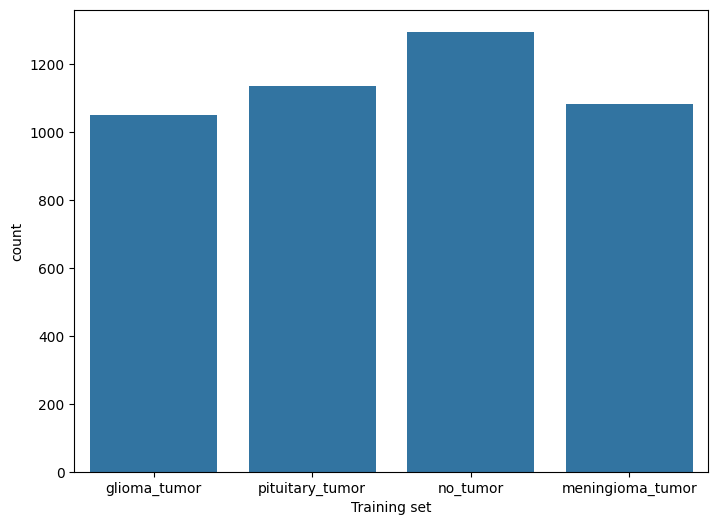

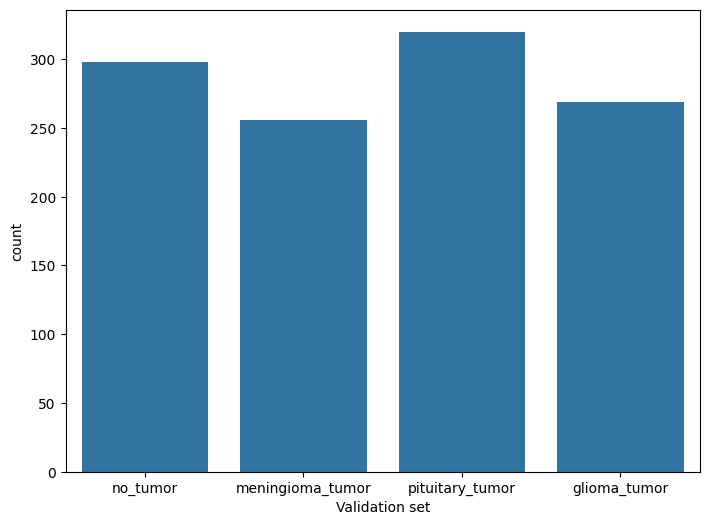

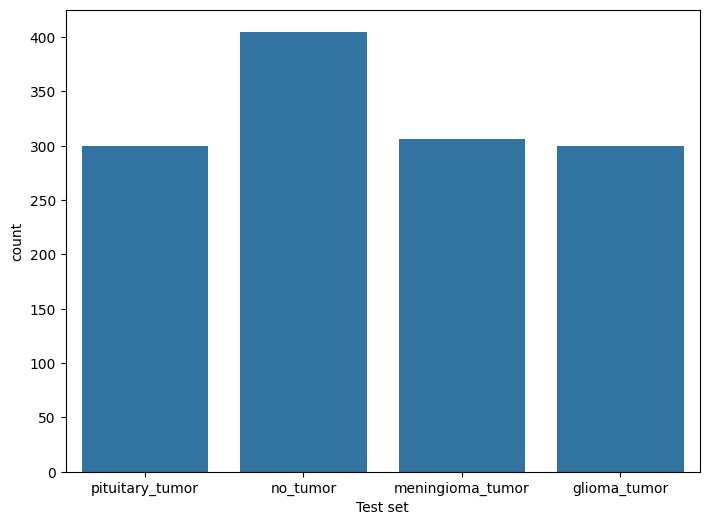

In [ ]:
plt.figure(figsize = (18, 6))
set = ['Training set']
for i, j in enumerate([y_train]):
    plt.subplot(1, 2, i+1)
    sns.countplot(x = j)
    plt.xlabel(set[i])

plt.figure(figsize = (18, 6))
set = ['Validation set']
for i, j in enumerate([y_val]):
    plt.subplot(1, 2, i+1)
    sns.countplot(x = j)
    plt.xlabel(set[i])


plt.figure(figsize = (18, 6))
set = ['Test set']
for i, j in enumerate([y_test]):
    plt.subplot(1, 2, i+1)
    sns.countplot(x = j)
    plt.xlabel(set[i])